In [11]:
import os
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import save_results
from ema_workbench import Model, MultiprocessingEvaluator, Policy, Scenario, Samplers, Constraint
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress, epsilon_nondominated
from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging

from problem_formulation import get_model_for_problem_formulation

### Convergence

In [ ]:
# problem formulation
problem_formulation_id = 7
model, planning_steps = get_model_for_problem_formulation(problem_formulation_id)

uncertainties = model.uncertainties
levers = model.levers
outcomes = model.outcomes

# === Load the selected scenarios ===
selected_cases = pd.read_csv("selected_cases.csv")
uncertainty_names = [u.name for u in uncertainties]  # must come from model.uncertainties

scenarios = {}
for case_label in selected_cases["Case"]:
    row = selected_cases[selected_cases["Case"] == case_label].iloc[0]
    filtered_dict = {key: row[key] for key in uncertainty_names if key in row}
    scenarios[case_label] = Scenario(name=case_label, **filtered_dict)

# === Set constraints ===
constraints = [
    Constraint("max expected number of death A.4", outcome_names="A.4_Expected Number of Deaths",
               function=lambda x: max(0, x - 10)),
    Constraint("max expected number of death A.5", outcome_names="A.5_Expected Number of Deaths",
               function=lambda x: max(0, x - 20)),
    Constraint("max expected annual damage A.4", outcome_names="A.4_Expected Annual Damage",
               function=lambda x: max(0, x - 5e8)),
    Constraint("max expected annual damage A.5", outcome_names="A.5_Expected Annual Damage",
               function=lambda x: max(0, x - 5e8)),
    Constraint("max dike investment A.4", outcome_names="A.4_Dike Investment Costs",
               function=lambda x: max(0, x - 6e8)),
    Constraint("max dike investment A.5", outcome_names="A.5_Dike Investment Costs",
               function=lambda x: max(0, x - 6e8)),
    Constraint("max RfR investment", outcome_names="RfR Total Costs",
               function=lambda x: max(0, x - 6e8)),
    Constraint("max evacuation cost", outcome_names="Expected Evacuation Costs",
               function=lambda x: max(0, x - 1e5))
]

# === Run convergence per scenario and seed ===
nfe = 2
n_seed = 3

for label, scenario in scenarios.items():
    for seed in range(n_seed):
        random.seed(seed)
        convergence_metrics = [
            ArchiveLogger(
                "./experiment",
                [l.name for l in model.levers],
                [o.name for o in model.outcomes],
                base_filename=f"results_optimize_{label}_{seed}.tar.gz",
            ),
            EpsilonProgress(),
        ]

        with MultiprocessingEvaluator(model) as evaluator:
            results, convergence = evaluator.optimize(
                nfe=nfe,
                searchover='levers',
                reference=scenario,
                epsilons=[0.025] * len(model.outcomes),
                convergence=convergence_metrics,
                constraints=constraints
            )

        convergence.to_csv(f"./mordm_Yao/convergence_results_optimize_{label}_{seed}_Yao.csv", index=False)
        print(f"Completed: Scenario={label}, Seed={seed}")


100it [00:04, 23.57it/s]                                                       


Completed: Scenario=Best, Seed=0


100it [00:05, 19.26it/s]                                                       


Completed: Scenario=Best, Seed=1


100it [00:05, 19.44it/s]                                                       


Completed: Scenario=Best, Seed=2


100it [00:05, 17.80it/s]                                                       


Completed: Scenario=Mediocre, Seed=0


100it [00:06, 15.66it/s]                                                       


Completed: Scenario=Mediocre, Seed=1


100it [00:06, 15.64it/s]                                                       


Completed: Scenario=Mediocre, Seed=2


100it [00:04, 20.25it/s]                                                       


Completed: Scenario=Worst, Seed=0


100it [00:06, 15.85it/s]                                                       


Completed: Scenario=Worst, Seed=1


100it [00:03, 26.09it/s]                                                       


Completed: Scenario=Worst, Seed=2


100it [00:03, 25.71it/s]                                                       


Completed: Scenario=Worst Dike 4, Seed=0


100it [00:03, 28.97it/s]                                                       


Completed: Scenario=Worst Dike 4, Seed=1


100it [00:04, 21.74it/s]                                                       


Completed: Scenario=Worst Dike 4, Seed=2


100it [00:03, 28.24it/s]                                                       


Completed: Scenario=Worst Dike 5, Seed=0


100it [00:03, 25.50it/s]                                                       


Completed: Scenario=Worst Dike 5, Seed=1


100it [00:03, 27.22it/s]                                                       


Completed: Scenario=Worst Dike 5, Seed=2


In [ ]:
def change_name_model(problem_id):
    model, planning_step = get_model_for_problem_formulation(problem_id)
    for u in model.levers:
        u.name = 'z_' + '_'.join(u.name.split(" "))
        u.name = u.name.replace('.', 'z')
    for u in model.outcomes:
        u.name = 'z_' + '_'.join(u.name.split(" "))
        u.name = u.name.replace('.', 'z')
    for u in model.uncertainties:
        u.name = 'z_' + '_'.join(u.name.split(" "))
        u.name = u.name.replace('.', 'z')
        return model

In [ ]:
def calculate_metrics(archives, reference_set, problem_id):
    model = change_name_model(problem_id)
    problem = to_problem(model, searchover="levers")
    hv = HypervolumeMetric(reference_set, problem)
    gd = GenerationalDistanceMetric(reference_set, problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set, problem)
    ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
    sm = SpacingMetric(problem)
    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "hypervolume": hv.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)
    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    return metrics

In [34]:
def get_calculate_metrics(problem_model, folder_name, n_seed, scenario):

    merge_archs = []
    metrics = []
    archives = []
    for seed in range(n_seed):
        arch = ArchiveLogger.load_archives(
            os.path.join(folder_name, f'results_optimize_{scenario}_{seed}.tar.gz'))
        for key in arch.keys():
            #arch[key] = arch[key].drop(columns='Unnamed: 0')
            arch[key] = arch[key].rename(columns={x: 'z_' + "_".join(x.split(" ")) for x in arch[key].columns})
            arch[key] = arch[key].rename(columns={x: x.replace('.', 'z') for x in arch[key].columns})
        merge_archs.extend([val for val in arch.values()])
        archives.append(arch)
    reference_set = epsilon_nondominated(merge_archs, [0.025] * len(problem_model.outcomes),
                                             to_problem(problem_model, searchover="levers"))
    for arch in archives:
        metric = calculate_metrics(arch, reference_set, problem_formulation_id)
        metrics.append(metric)
    return metrics, reference_set

In [42]:
def plot_metrics(metrics, convergences, scenario):
    # sns.set_style("white")

    # fig2save = plt.gcf()
    fig, axes = plt.subplots(nrows=2, figsize=(4, 6), sharex=True)
    ax1, ax2 = axes
    for metric, convergence in zip(metrics, convergences):
        ax1.plot(convergence.nfe, convergence.epsilon_progress)
        ax1.set_ylabel("$\epsilon$ progress")
        ax2.plot(metric.nfe, metric.hypervolume)
        ax2.set_ylabel("hypervolume")
        ax2.set_xlabel("nfe")
    sns.despine(fig)
    fig.savefig(os.path.join(
        folder, f'convergence_results_optimize_{scenario}.png'))
    plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
C:\Users\yaowa\AppData\Local\Temp\ipykernel_10744\743043402.py:9: SyntaxWarning: invalid escape sequence '\e'
  ax1.set_ylabel("$\epsilon$ progress")


In [36]:
list(scenarios.keys())

['Best', 'Mediocre', 'Worst', 'Worst Dike 4', 'Worst Dike 5']

Best


c:\Users\yaowa\.conda\envs\abm24\Lib\site-packages\ema_workbench\em_framework\optimization.py:786: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat(results, ignore_index=True)


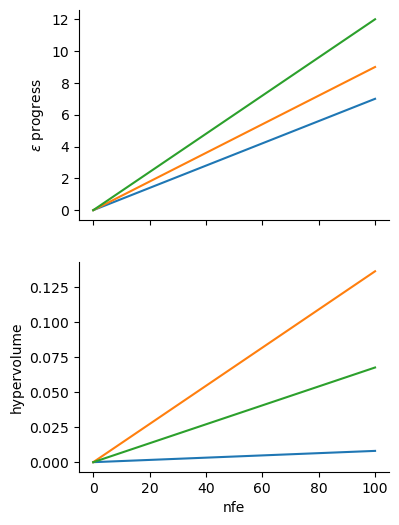

Mediocre


c:\Users\yaowa\.conda\envs\abm24\Lib\site-packages\ema_workbench\em_framework\optimization.py:786: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat(results, ignore_index=True)


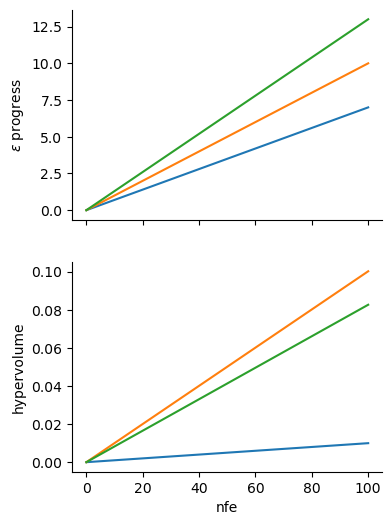

Worst


c:\Users\yaowa\.conda\envs\abm24\Lib\site-packages\ema_workbench\em_framework\optimization.py:786: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat(results, ignore_index=True)


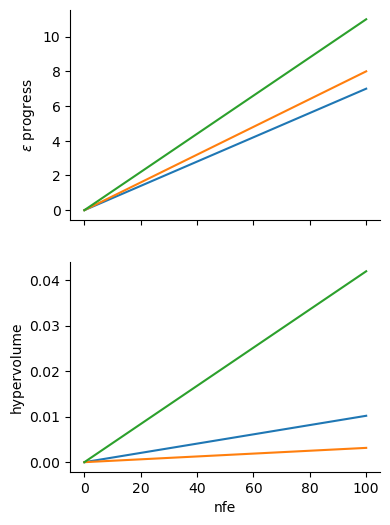

Worst Dike 4


c:\Users\yaowa\.conda\envs\abm24\Lib\site-packages\ema_workbench\em_framework\optimization.py:786: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat(results, ignore_index=True)


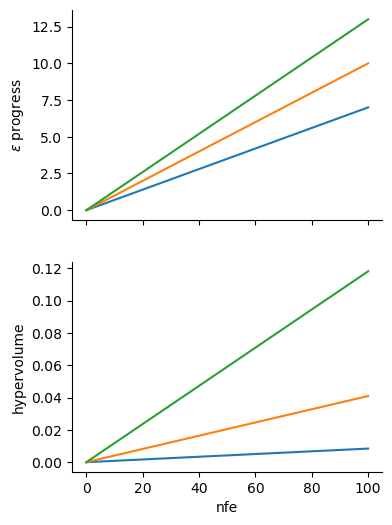

Worst Dike 5


c:\Users\yaowa\.conda\envs\abm24\Lib\site-packages\ema_workbench\em_framework\optimization.py:786: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat(results, ignore_index=True)


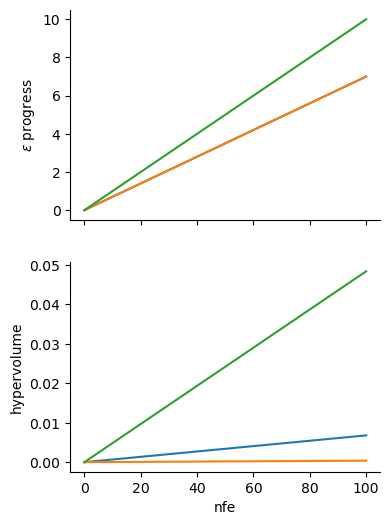

In [ ]:

problem_formulation_id = 7
model = change_name_model(problem_formulation_id)

folder = 'mordm_Yao'
seed_num = 3

for label in list(scenarios.keys()):
    print(label)

    metrics, reference_set = get_calculate_metrics(model, folder, seed_num, label)
    reference_set.to_csv(
        os.path.join(folder, f'reference_set_scenario_{label}.csv'),
        index=False
    )

    convergences = [
        pd.read_csv(os.path.join(folder, f'convergence_results_optimize_{label}_{seed}_Yao.csv'))
        for seed in range(seed_num)
    ]

    plot_metrics(metrics, convergences, label)